# Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to **File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.



---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Write your Algorithm
* [Step 6](#step6): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

Make sure that you've downloaded the required human and dog datasets:
* Download the [dog dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip).  Unzip the folder and place it in this project's home directory, at the location `/dogImages`. 

* Download the [human dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip).  Unzip the folder and place it in the home directory, at location `/lfw`.  

*Note: If you are using a Windows machine, you are encouraged to use [7zip](http://www.7-zip.org/) to extract the folder.*

In the code cell below, we save the file paths for both the human (LFW) dataset and dog dataset in the numpy arrays `human_files` and `dog_files`.

In [172]:
# Imports
import numpy as np
from glob import glob
import os
import cv2
import matplotlib.pyplot as plt                        
from tqdm import tqdm
from PIL import Image, ImageFile

import torch
import torchvision.models as models
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# the following import is required for training to be robust to truncated images
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [173]:
# check if CUDA is available
use_cuda = torch.cuda.is_available()
print('Using CUDA', use_cuda)

def clear_gpu_memory(data):
    if use_cuda:
        for i in data:
            del i
        torch.cuda.empty_cache()

Using CUDA True


In [316]:
def open_log_file(name):
    return open(name + '.txt', "a+")

def append_log_file(file, contents):
    file.write(contents)

def save_model_representation(file, model):
    file.write(repr(model) + '\n')

In [174]:
# load filenames for human and dog images
human_files = np.array(glob("lfw/*/*"))
dog_files = np.array(glob("dogImages/*/*/*"))

# print number of images in each dataset
print('There are %d total human images.' % len(human_files))
print('There are %d total dog images.' % len(dog_files))

There are 2874 total human images.
There are 8351 total dog images.


<a id='step1'></a>
## Step 1: Detect Humans

In this section, we use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  

OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.  In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


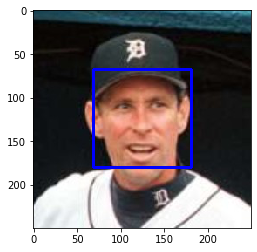

In [324]:
%matplotlib inline                               

def bound_box_around_face(img):
    # extract pre-trained face detector
    face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

    # load color (BGR) image
    img = cv2.imread(img)
    # convert BGR image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # find faces in image
    faces = face_cascade.detectMultiScale(gray)

    # print number of faces detected in the image
    print('Number of faces detected:', len(faces))

    # get bounding box for each detected face
    for (x,y,w,h) in faces:
        # add bounding box to color image
        cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)

    # convert BGR image to RGB for plotting
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # display the image, along with bounding box
    plt.imshow(cv_rgb)
    plt.show()

bound_box_around_face(human_files[0])

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [176]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face? 
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 
(You can print out your results and/or write your percentages in this cell)

100% of human faces are detected

13% of dog images have a human face detected

In [177]:
human_files_short = human_files[:100]
dog_files_short = dog_files[:100]

In [180]:
## Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.
num_faces = 0
num_faces_in_dog_img = 0
for i in tqdm(range(100)):
    human = human_files_short[i]
    dog = dog_files_short[i]
    if face_detector(human):
        num_faces += 1            
    if face_detector(dog):
        num_faces_in_dog_img += 1

print('Human faces detected in human_files_short', num_faces)
print('Human faces detected in dog_files_short', num_faces_in_dog_img)

100%|██████████| 100/100 [00:10<00:00, 11.42it/s]

Human faces detected in human_files_short 100
Human faces detected in dog_files_short 13


We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a [pre-trained model](http://pytorch.org/docs/master/torchvision/models.html) to detect dogs in images.  

### Obtain Pre-trained VGG-16 Model

The code cell below downloads the VGG-16 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  

In [181]:
# define VGG16 model
VGG16 = models.vgg16(pretrained=True)
# move model to GPU if CUDA is available
if use_cuda:
    VGG16 = VGG16.cuda()

Given an image, this pre-trained VGG-16 model returns a prediction (derived from the 1000 possible categories in ImageNet) for the object that is contained in the image.

### (IMPLEMENTATION) Making Predictions with a Pre-trained Model

In the next code cell, you will write a function that accepts a path to an image (such as `'dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg'`) as input and returns the index corresponding to the ImageNet class that is predicted by the pre-trained VGG-16 model.  The output should always be an integer between 0 and 999, inclusive.

Before writing the function, make sure that you take the time to learn  how to appropriately pre-process tensors for pre-trained models in the [PyTorch documentation](http://pytorch.org/docs/stable/torchvision/models.html).

In [182]:
def process_img(img_path):
    '''
    Processes an image for input to a vgg16 net.
    Resizes so shortest side is 255 while preserving aspect ratio, crops the center 224x224,
    normalizes pixels, then returns it as a pytorch float tensor.
    
    Args:
        img_path: path to an image
    
    Returns:
        Pytorch Float tensor representing cropped and normalized image ready for pretrained pytorch model
    '''
    img = Image.open(img_path)
    width, height = img.size
    
    # resize so the shortest size is 255 pixels while preserving aspect ratio
    if width < height:
        img.resize((255, int(255 * height / width)))
    else:
        img.resize((int(255 * width / height), 255))
    
    # the new diemnsions
    width, height = img.size
    
    # center crop a 224x224 box
    left = (width - 224) / 2
    top = (height - 224) / 2 
    right = (width + 224) / 2
    bottom = (height + 224) / 2
    img = img.crop((left, top, right, bottom))
    
    img = np.array(img)
    # Make the color channel dimension first instead of last
    img = img.transpose((2, 0, 1)) # 3x224x224

    # convert all pixel values to between 0 and 1
    img = img / 255 
    # then normalize using means 0.485, 0.456, 0.406 and medians 0.229, 0.224, 0.225
    img[0] = (img[0] - 0.485) / 0.229 
    img[1] = (img[1] - 0.456) / 0.224
    img[2] = (img[2] - 0.406) / 0.225
    img = img[np.newaxis, : ] # create dimension for batch size of 1, so img.shape is 1x3x224x224
    
    # turn into tensor
    torch_img = torch.from_numpy(img)
    # turn into float tensor
    torch_img = torch_img.float()
    if use_cuda:
        torch_img = torch_img.cuda()
    return torch_img

In [183]:
def VGG16_predict(img_path):
    '''
    Use pre-trained VGG-16 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to VGG-16 model's prediction
    '''    
    processed_img = process_img(img_path)
    return VGG16(processed_img) # predicted class index

### (IMPLEMENTATION) Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained VGG-16 model, we need only check if the pre-trained model predicts an index between 151 and 268 (inclusive).

Use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [184]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    predictions =  VGG16_predict(img_path)
    _, index = predictions.topk(1, dim=1)
    isDog = 151 <= index <= 268
    return isDog

### (IMPLEMENTATION) Assess the Dog Detector

__Question 2:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 

95% of dog images contain a recognized dog.

0% of human images were fonud to contain dog by the network.

In [185]:
### Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.
num_dogs = 0
num_mistaken_human_for_dog = 0
for i in tqdm(range(100)):
    human = human_files_short[i]
    dog = dog_files_short[i]  
    if dog_detector(dog):
        num_dogs += 1
    if dog_detector(human):
        num_mistaken_human_for_dog += 1
    

print('Dogs detected in dog images {}%'.format(num_dogs))
print('Humans that was deemed a dog {}%'.format(num_mistaken_human_for_dog))

100%|██████████| 100/100 [00:04<00:00, 24.02it/s]

Dogs detected in dog images 95%
Humans that was deemed a dog 0%


We suggest VGG-16 as a potential network to detect dog images in your algorithm, but you are free to explore other pre-trained networks (such as [Inception-v3](http://pytorch.org/docs/master/torchvision/models.html#inception-v3), [ResNet-50](http://pytorch.org/docs/master/torchvision/models.html#id3), etc).  Please use the code cell below to test other pre-trained PyTorch models.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 10%.  In Step 4 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have trouble distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively).  You may find [this documentation on custom datasets](http://pytorch.org/docs/stable/torchvision/datasets.html) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [186]:
### Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes
train_dir = './dogImages/train'
valid_dir = './dogImages/valid'
test_dir = './dogImages/test'
batch_size = 20

train_transforms = transforms.Compose([transforms.RandomRotation(15),
                                        transforms.RandomResizedCrop(224),
                                        transforms.RandomHorizontalFlip(),
                                        transforms.ToTensor(),
                                        transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

valid_transforms = transforms.Compose([transforms.Resize(255), 
                                        transforms.CenterCrop(224),
                                        transforms.ToTensor(),
                                        transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(255), 
                                        transforms.CenterCrop(224),
                                        transforms.ToTensor(),
                                        transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
valid_dataset = datasets.ImageFolder(valid_dir, transform=valid_transforms)
test_dataset = datasets.ImageFolder(test_dir, transform=test_transforms)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size)

loaders_scratch = {
    'train': train_loader, 
    'valid': valid_loader, 
    'test': test_loader
}

**Question 3:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?


**Answer**:
The train images are randomly rotated 15 degrees, cropped and resized with random size and aspect ratio, resized to to 224x224 pixels, and horizontally flipped with probability 50%. This is to introduce variation to the images to learn spatial orientation changes of dogs. The images are then normalized using ImageNet mean and variances for each of the colour channels. The input tensors are 224x224 becaus 224 is divisble by 2 several times which is helpful for max pooling layers.
The validation and test images are resized and center cropped to 224x224 pixels. Random augmentations are not performed as these images are not used for training and don't require the 

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  Use the template in the code cell below.

In [29]:
# 8 conv layers with batch normalization
class NetBN(nn.Module):
    def __init__(self):
        super(NetBN, self).__init__()
        
        conv1_out = 64
        conv2_out = 64
        conv3_out = 128
        conv4_out = 128
        conv5_out = 128
        conv6_out = 256
        conv7_out = 512
        conv8_out = 512
        
        num_classes = 133 # number of dog breeds
        self.fc_input_size = conv8_out * 7 * 7 # 7 is size of features after all max pooling layers
        
        self.conv1 = nn.Conv2d(3, conv1_out, 3, padding=1)
        self.conv2 = nn.Conv2d(conv1_out, conv2_out, 3, padding=1)
        self.conv3 = nn.Conv2d(conv2_out, conv3_out, 3, padding=1)
        self.conv4 = nn.Conv2d(conv3_out, conv4_out, 3, padding=1)
        self.conv5 = nn.Conv2d(conv4_out, conv5_out, 3, padding=1)
        self.conv6 = nn.Conv2d(conv5_out, conv6_out, 3, padding=1)
        self.conv7 = nn.Conv2d(conv6_out, conv7_out, 3, padding=1)
        self.conv8 = nn.Conv2d(conv7_out, conv8_out, 3, padding=1)

        self.conv1_bn = nn.BatchNorm2d(conv1_out)
        self.conv2_bn = nn.BatchNorm2d(conv2_out)
        self.conv3_bn = nn.BatchNorm2d(conv3_out)
        self.conv4_bn = nn.BatchNorm2d(conv4_out)
        self.conv5_bn = nn.BatchNorm2d(conv5_out)
        self.conv6_bn = nn.BatchNorm2d(conv6_out)
        self.conv7_bn = nn.BatchNorm2d(conv7_out)
        self.conv8_bn = nn.BatchNorm2d(conv8_out)
        
        self.pool = nn.MaxPool2d(2, 2)
        
        self.fc1 = nn.Linear(self.fc_input_size, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3_out = nn.Linear(4096, num_classes)  
        
        self.dropout = nn.Dropout(0) # start with p=0 initially. BatchNorm reduces the need for dropout.
        
    def forward(self, x):
        # input x: 20x3x224x224 (batch_size x depth x width x height)
        # CONV -> BN -> ReLU -> MaxPool -> FC w ReLU -> Linear output
        
        # Convolutional layers
        x = F.relu(self.conv1_bn(self.conv1(x)))
        x = self.pool(x)
        
        x = F.relu(self.conv2_bn(self.conv2(x)))
        x = self.pool(x)
        
        x = F.relu(self.conv3_bn(self.conv3(x)))
        x = F.relu(self.conv4_bn(self.conv4(x))) 
        x = self.pool(x)           
        
        x = F.relu(self.conv5_bn(self.conv5(x)))
        x = F.relu(self.conv6_bn(self.conv6(x))) 
        x = self.pool(x)        
        
        x = F.relu(self.conv7_bn(self.conv7(x)))
        x = F.relu(self.conv8_bn(self.conv8(x))) 
        x = self.pool(x)           
        
        # flatten for FC layers
        x = x.view(-1, self.fc_input_size)
        
        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        # using CrossEntropyLoss which combines LogSoftmax and NLLLoss, so no activation function here
        x = self.fc3_out(x) 
        return x

In [5]:
# 8 conv layers with batch normalization
class NetBN_Deep(nn.Module):
    def __init__(self, num_classes):
        super(NetBN_Deep, self).__init__()
        conv1_out = 64
        conv2_out = 64
        conv3_out = 64
        conv4_out = 64
        
        conv5_out = 128
        conv6_out = 128
        conv7_out = 128
        
        conv8_out = 128
        conv9_out = 256
        conv10_out = 256
        
        conv11_out = 256
        conv12_out = 256
        conv13_out = 512
        
        conv14_out = 512
        conv15_out = 512
        conv16_out = 512
        
        self.conv1 = nn.Conv2d(3, conv1_out, 3, padding=1)
        self.conv2 = nn.Conv2d(conv1_out, conv2_out, 3, padding=1)
        self.conv3 = nn.Conv2d(conv2_out, conv3_out, 3, padding=1)
        self.conv4 = nn.Conv2d(conv3_out, conv4_out, 3, padding=1)
        
        self.conv5 = nn.Conv2d(conv4_out, conv5_out, 3, padding=1)
        self.conv6 = nn.Conv2d(conv5_out, conv6_out, 3, padding=1)
        self.conv7 = nn.Conv2d(conv6_out, conv7_out, 3, padding=1)
        
        self.conv8 = nn.Conv2d(conv7_out, conv8_out, 3, padding=1)
        self.conv9 = nn.Conv2d(conv8_out, conv9_out, 3, padding=1)
        self.conv10 = nn.Conv2d(conv9_out, conv10_out, 3, padding=1)
        
        self.conv11 = nn.Conv2d(conv10_out, conv11_out, 3, padding=1)
        self.conv12 = nn.Conv2d(conv11_out, conv12_out, 3, padding=1)
        self.conv13 = nn.Conv2d(conv12_out, conv13_out, 3, padding=1)
        
        self.conv14 = nn.Conv2d(conv13_out, conv14_out, 3, padding=1)
        self.conv15 = nn.Conv2d(conv14_out, conv15_out, 3, padding=1)
        self.conv16 = nn.Conv2d(conv15_out, conv16_out, 3, padding=1)

        self.bn64 = nn.BatchNorm2d(64)
        self.bn128 = nn.BatchNorm2d(128)
        self.bn256 = nn.BatchNorm2d(256)
        self.bn512 = nn.BatchNorm2d(512)
        
        self.pool = nn.MaxPool2d(2, 2)
        
        self.fc_input_size = conv16_out * 7 * 7 # 7 is size of features after all max pooling
        self.fc1 = nn.Linear(self.fc_input_size, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3_out = nn.Linear(4096, num_classes)  
        
        self.dropout = nn.Dropout(0) # start with p=0 initially. BatchNorm reduces the need for dropout.
        
    def forward(self, x):
        # input x: 20x3x224x224 (batch_size x depth x width x height)
        
        # Convolutional layers
        x = F.relu(self.bn64(self.conv1(x)))
        x = F.relu(self.bn64(self.conv2(x)))
        x = F.relu(self.bn64(self.conv3(x)))
        x = F.relu(self.bn64(self.conv4(x)))
        x = self.pool(x)
        
        x = F.relu(self.bn128(self.conv5(x)))
        x = F.relu(self.bn128(self.conv6(x)))
        x = F.relu(self.bn128(self.conv7(x)))
        x = self.pool(x)

        x = F.relu(self.bn128(self.conv8(x)))
        x = F.relu(self.bn256(self.conv9(x)))
        x = F.relu(self.bn256(self.conv10(x)))
        x = self.pool(x)
        
        x = F.relu(self.bn256(self.conv11(x)))
        x = F.relu(self.bn256(self.conv12(x)))
        x = F.relu(self.bn512(self.conv13(x)))
        x = self.pool(x)
        
        x = F.relu(self.bn512(self.conv14(x)))
        x = F.relu(self.bn512(self.conv15(x)))
        x = F.relu(self.bn512(self.conv16(x)))
        x = self.pool(x)
        
        # flatten for FC layers
        x = x.view(-1, self.fc_input_size)
        
        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        # using CrossEntropyLoss which combines LogSoftmax and NLLLoss, so no activation function here
        x = self.fc3_out(x) 
        
        return x

In [ ]:
class Maxout(nn.Module):
    def __init__(self, pool_size):
        super().__init__()
        self._pool_size = pool_size

    def forward(self, x):
        assert x.shape[1] % self._pool_size == 0, \
            'Wrong input last dim size ({}) for Maxout({})'.format(x.shape[1], self._pool_size)
        m, i = x.view(*x.shape[:1], 
                      x.shape[1] // self._pool_size,
                      self._pool_size,
                      *x.shape[2:]).max(2)
        return m

In [ ]:
# 8 conv layers with batch normalization and maxout instead of relu
class NetBN_MO(nn.Module):
    def __init__(self):
        super(NetBN_MO, self).__init__()
        
        conv1_out = 64
        conv2_out = 64
        conv3_out = 128
        conv4_out = 128
        conv5_out = 128
        conv6_out = 256
        conv7_out = 512
        conv8_out = 512
        
        num_classes = 133 # number of dog breeds
        self.fc_input_size = conv8_out * 7 * 7 # 7 is size of features after all max pooling layers
        
        self.conv1 = nn.Conv2d(3, conv1_out, 3, padding=1)
        self.conv2 = nn.Conv2d(conv1_out, conv2_out, 3, padding=1)
        self.conv3 = nn.Conv2d(conv2_out, conv3_out, 3, padding=1)
        self.conv4 = nn.Conv2d(conv3_out, conv4_out, 3, padding=1)
        self.conv5 = nn.Conv2d(conv4_out, conv5_out, 3, padding=1)
        self.conv6 = nn.Conv2d(conv5_out, conv6_out, 3, padding=1)
        self.conv7 = nn.Conv2d(conv6_out, conv7_out, 3, padding=1)
        self.conv8 = nn.Conv2d(conv7_out, conv8_out, 3, padding=1)

        self.conv1_bn = nn.BatchNorm2d(conv1_out)
        self.conv2_bn = nn.BatchNorm2d(conv2_out)
        self.conv3_bn = nn.BatchNorm2d(conv3_out)
        self.conv4_bn = nn.BatchNorm2d(conv4_out)
        self.conv5_bn = nn.BatchNorm2d(conv5_out)
        self.conv6_bn = nn.BatchNorm2d(conv6_out)
        self.conv7_bn = nn.BatchNorm2d(conv7_out)
        self.conv8_bn = nn.BatchNorm2d(conv8_out)
        
        
        self.pool = nn.MaxPool2d(2, 2)
        
        self.fc1 = nn.Linear(self.fc_input_size, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3_out = nn.Linear(4096, num_classes)  
        
        self.dropout = nn.Dropout(0) # start with p=0 initially. BatchNorm reduces the need for dropout.
        
    def forward(self, x):
        # input x: 20x3x224x224 (batch_size x depth x width x height)
        # CONV -> BN -> Maxout -> MaxPool -> FC w ReLU -> Linear output
        
        # Convolutional layers
        x = self.conv1(x)
        x = self.conv1_bn(x)
        x = self.pool(x)
        x = self.maxout(x)
        
        x = self.conv2(x)
        x = self.conv2_bn(x)
        x = self.pool(x)
        x = self.maxout(x)
        
        x = self.conv3(x)
        x = self.conv3_bn(x)
        x = self.maxout(x)
        x = self.conv4(x)
        x = self.conv4_bn(x)
        x = self.maxout(x)
        x = self.pool(x)           
        
        x = self.conv5(x)
        x = self.conv5_bn(x)
        x = self.maxout(x)
        x = self.conv6(x)
        x = self.conv6_bn(x)
        x = self.maxout(x)
        x = self.pool(x)           
        
        x = self.conv7(x)
        x = self.conv7_bn(x)
        x = self.maxout(x)
        x = self.conv8(x)
        x = self.conv8_bn(x)
        x = self.maxout(x)
        x = self.pool(x)                      
        
        # flatten for FC layers
        x = x.view(-1, self.fc_input_size)
        
        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        # using CrossEntropyLoss which combines LogSoftmax and NLLLoss, so no activation function here
        x = self.fc3_out(x) 
        return x
    def maxout(self, x):
        pass

In [30]:
# instantiate the CNN
model_scratch = NetBN()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

model_scratch

NetBN(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv7): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv8): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_s

__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__ 

My initial network consisted of 5 convolutional layers and 3 fully connected layers with dropout levels at 0.25. This network didn't learn. I then removed dropout and added 3 convolutional layers, which also did not work. After doing some research, I came across the batch normalization technique. Adding batch normalization after every convolution significantly sped up learning. After 1 epoch it reached 2% accuracy compared to 1% accuracy after >5 epochs with previous models. The training was supervised by hand as I did not know about the learning rate schedulers at this point - training was stopped, LR lowered, and training restarted when validation loss stopped decreasing. Dropout intensity was gradually increased as well to prevent overfitting.

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and the optimizer as `optimizer_scratch` below.

In [33]:
learning_rate = 0.15
criterion_scratch = nn.CrossEntropyLoss()
optimizer_scratch = optim.SGD(params=model_scratch.parameters(), lr=learning_rate)

Here I defined model save and load functions, saving the optimizer state along with the model's parameters to allow for training continuation.

In [259]:
def save_model(model_name, model_state_dict, optim_state_dict, 
               accuracy, epoch, min_valid_loss, save_path):
    checkpoint = {
        "model_name": model_name,
        "model_state_dict": model_state_dict,
        "optim_state_dict": optim_state_dict,
        "validation_accuracy": accuracy,
        "epoch": epoch,
        "min_valid_loss": min_valid_loss
    }
    torch.save(checkpoint, save_path)
    print("Model saved")
    
def load_model(model, optim, checkpoint_name):
    try:
        checkpoint = torch.load(checkpoint_name)
        model.load_state_dict(checkpoint['model_state_dict'])
        optim.load_state_dict(checkpoint['optim_state_dict'])
        accuracy = checkpoint["validation_accuracy"]
        min_valid_loss = checkpoint["min_valid_loss"]
        epoch = checkpoint['epoch'] # left off on epoch #
        print("Loaded a model. \tAccuracy: {} \tMin valid loss: {}".format(accuracy.item(), min_valid_loss))
        print('Achieved on epoch ', epoch)
        return epoch, min_valid_loss     
    except FileNotFoundError:
        print('Model checkpoint does not exist')

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `save_path`.

In [27]:
save_path_bn = 'model_scratch_BN.pt'
save_path_bn_deep = 'model_scratch_BN_deep.pt'
save_path_bn_mo = 'model_scratch_BN_Maxout.pt'
save_path = save_path_bn

In [12]:
def change_learning_rate(optimizer, by_factor, log_file):
    for param_group in optimizer.param_groups:
        previous_lr = param_group['lr']
        param_group['lr'] *= by_factor
        print("Changed LR: {} -> {}".format(previous_lr, param_group['lr']))
        
def change_dropout_intensity(model, intensity=0, log_file):
    if 0 < intensity < 1:
        model.dropout.p = intensity
        print('Set dropout to ', intensity)
    elif model.dropout.p < 0.5:
        if model.dropout.p == 0:
            model.dropout.p += 0.1
        else:
            model.dropout.p += 0.05
        print('Increasing dropout to ', model.dropout.p)
    else:
        print('Maximum dropout reached')

In [307]:
def train(n_epochs, loaders, model, optimizer, criterion, 
          use_cuda, save_path, schedulers, log_file, resume_epoch=1, valid_loss_min = np.Inf):
    """returns trained model"""
    print('Training model', save_path)
    append_log_file(log_file, 'Training model' + save_path + '\n')
    auto_change_dropout = False

    for epoch in range(resume_epoch, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0

        accuracy = 0.0
        correct = 0.
        total = 0.

        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## find the loss and update the model parameters accordingly
            ## record the average training loss
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            train_loss += (1 / (batch_idx + 1)) * (loss.data - train_loss)
            clear_gpu_memory([data, target, output, loss])

            if (batch_idx + 1) % batch_size == 0:
                text = 'Batch: {}, Training Loss: {:.6f}'.format(batch_idx + 1, train_loss) 
                print(text)
                append_log_file(log_file, text)

        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            with torch.no_grad():
                # move to GPU
                if use_cuda:
                    data, target = data.cuda(), target.cuda()
                ## update the average validation loss
                output = model(data)
                loss = criterion(output, target)
                valid_loss += (1 / (batch_idx + 1)) * (loss.data - valid_loss)

                # convert output probabilities to predicted class
                pred = output.data.max(1, keepdim=True)[1]
                # compare predictions to true label
                correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
                total += data.size(0)

                clear_gpu_memory([data, target])
        
        if 'valid' in schedulers:
            valid_scheduler = schedulers['valid']
            valid_scheduler.step(valid_loss)
            
        # increase dropout
        if auto_change_dropout and train_loss - valid_loss < 0.15: 
            print('Auto increasing dropout')
            change_dropout_intensity(model)
            if model.dropout.p > 0.2:
                auto_change_dropout = False

        # print training/validation statistics
        accuracy = 100. * correct / total
        summary_batch_run_text = 'Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}\nValid Accuracy: {:.3f}% ({}/{})\n'.format(
            epoch, 
            train_loss,
            valid_loss,
            accuracy,
            correct, total
        )
        print(summary_batch_run_text)
        append_log_file(log_file, summary_batch_run_text)

        ## save the model if validation loss has decreased
        if valid_loss < valid_loss_min:
            print('Saving model')
            append_log_file(log_file, 'Model saved')
            save_model(model_name=save_path, 
                       model_state_dict=model.state_dict(), 
                       optim_state_dict=optimizer.state_dict(), 
                       accuracy=accuracy, epoch=epoch, min_valid_loss=valid_loss,
                       save_path=save_path)
            valid_loss_min = valid_loss
        print('\n')
    # return trained model
    return model

In [ ]:
continue_training = False
try:
    if continue_training:
        print('Training continued')
        resume_epoch, min_valid_loss = load_model(model_scratch, optimizer_scratch, save_path)    

        #change_dropout_intensity(model_scratch, 0.4)
        change_learning_rate(optimizer_scratch, 0.4)

        model_scratch = train(100, 
                              loaders_scratch, model_scratch, 
                              optimizer_scratch, criterion_scratch, 
                              use_cuda, save_path, 
                              resume_epoch = resume_epoch, valid_loss_min=min_valid_loss)
    else:
        # train the model
        print('Training started')
        model_scratch = train(100, loaders_scratch, model_scratch, 
                              optimizer_scratch, criterion_scratch, 
                              use_cuda, save_path)

    # load the model that got the best validation accuracy
    load_model(model_scratch, optimizer_scratch, save_path)
except KeyboardInterrupt:
    print('Training interrupted')

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images.  Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 10%.

In [189]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)

        if use_cuda:
            del data
            del target
            torch.cuda.empty_cache()
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

In [ ]:
# load the model that got the best validation accuracy
load_model(model_scratch, optimizer_scratch, save_path)
# call test function    
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

---
<a id='step4'></a>
## Step 4: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively). 

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [190]:
loaders_transfer = loaders_scratch

### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify dog breed.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [260]:
import torchvision.models as models
import torch.nn as nn

def weights_init_normal(m):
    '''Takes in a module and initializes last fc linear layer with 
        weight values taken from a normal distribution.'''
    
    classname = m.__class__.__name__
    # m.weight.data shoud be taken from a normal distribution
    # m.bias.data should be 0
    if classname.find('Linear') != -1:
        m.weight.data.normal_(0, 1.0/np.sqrt(m.in_features))
        m.bias.data.fill_(0)

model_transfer = models.resnet50(pretrained=True)
model_transfer.fc = nn.Linear(model_transfer.fc.in_features, 133)
model_transfer.fc.apply(weights_init_normal)

for param in model_transfer.parameters():
    param.requires_grad = False
for param in model_transfer.fc.parameters():
    param.requires_grad = True

if use_cuda:
    model_transfer = model_transfer.cuda()

model_transfer

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ 

Since the dog image dataset is relatively small (couple thousand images) and similar to the ImageNet dog dataset ResNet50 was pretrained on, I chose to only retrain the last linear layer. I replaced the layer with a new 2048->133 linear layer. 133 is the number of output features as this is the number of dog breeds we have in the dataset. The rest of the network is already an excellent feature extractor. Hence, requires_grad is set to false for every layer except the last.

The last layer's weights were initialized according to a normal distribution but this had very little effect on accuracy since only a small fraction of weights were initialized in this manner and the rest of the network weights are already well chosen (and frozen). 

Learning rate choice: After some experimentation, I started with lr=0.075. This seemed to be the sweet spot where the training loss would start lower than with higher learning rates, not much higher than with a lower rate, and decrease faster than it would with lower learning rates. Furthermore, I used a learning rate scheduler that reduced the learning rate by half when it detects validation loss has stopped decreasing for 1 epoch. Some additional learning occured after each decrease in learning rate but I noticed that training loss would begin to increase/stabilize around epoch 18-20. The model was allowed to train until epoch 38 where training was stopped. The model achieved 89% accuracy on the test set.

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/master/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/master/optim.html).  Save the chosen loss function as `criterion_transfer`, and the optimizer as `optimizer_transfer` below.

In [308]:
learning_rate_transfer = 0.02
criterion_transfer = nn.CrossEntropyLoss()
optimizer_transfer = optim.SGD(params=model_transfer.parameters(), lr=learning_rate_transfer)
scheduler_valid_transfer = optim.lr_scheduler.ReduceLROnPlateau(optimizer_transfer, factor=0.5, patience=1, verbose=True)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [313]:
save_path_resnet = 'model_transfer_resnet50.pt'
save_path_resnet_2 = 'model_transfer_resnet50_2.pt'
save_path_transfer = save_path_resnet

In [263]:
try:
    model_transfer = train(50, loaders_transfer, model_transfer, optimizer_transfer, criterion_transfer, 
                           use_cuda, save_path_transfer, schedulers={'valid': scheduler_valid_transfer})
except KeyboardInterrupt:
    print('Training interrupted.')

Training model model_transfer_resnet50.pt
Batch: 20, Training Loss: 5.102212
Batch: 40, Training Loss: 4.821164
Batch: 60, Training Loss: 4.505368
Batch: 80, Training Loss: 4.260410
Batch: 100, Training Loss: 4.020576
Batch: 120, Training Loss: 3.815931
Batch: 140, Training Loss: 3.628956
Batch: 160, Training Loss: 3.456011
Batch: 180, Training Loss: 3.325509
Batch: 200, Training Loss: 3.193416
Batch: 220, Training Loss: 3.075784
Batch: 240, Training Loss: 2.984688
Batch: 260, Training Loss: 2.893465
Batch: 280, Training Loss: 2.823284
Batch: 300, Training Loss: 2.749756
Batch: 320, Training Loss: 2.677194
Epoch: 1 	Training Loss: 2.641583 	Validation Loss: 0.880851
Valid Accuracy: 74.970% (626.0/835.0)
Saving model
Model saved


Batch: 20, Training Loss: 1.400561
Batch: 40, Training Loss: 1.465049
Batch: 60, Training Loss: 1.456913
Batch: 80, Training Loss: 1.458644
Batch: 100, Training Loss: 1.455655
Batch: 120, Training Loss: 1.439780
Batch: 140, Training Loss: 1.429417
Batch: 160, 

Batch: 320, Training Loss: 0.806135
Epoch: 12 	Training Loss: 0.808116 	Validation Loss: 0.489760
Valid Accuracy: 83.353% (696.0/835.0)


Batch: 20, Training Loss: 0.768464
Batch: 40, Training Loss: 0.747709
Batch: 60, Training Loss: 0.714866
Batch: 80, Training Loss: 0.727036
Batch: 100, Training Loss: 0.722767
Batch: 120, Training Loss: 0.714311
Batch: 140, Training Loss: 0.713261
Batch: 160, Training Loss: 0.721679
Batch: 180, Training Loss: 0.730063
Batch: 200, Training Loss: 0.734674
Batch: 220, Training Loss: 0.734676
Batch: 240, Training Loss: 0.730206
Batch: 260, Training Loss: 0.742475
Batch: 280, Training Loss: 0.742444
Batch: 300, Training Loss: 0.744619
Batch: 320, Training Loss: 0.755998
Epoch    12: reducing learning rate of group 0 to 3.7500e-02.
Epoch: 13 	Training Loss: 0.759219 	Validation Loss: 0.449208
Valid Accuracy: 85.509% (714.0/835.0)


Batch: 20, Training Loss: 0.802760
Batch: 40, Training Loss: 0.736681
Batch: 60, Training Loss: 0.718120
Batch: 80, Training L

Batch: 200, Training Loss: 0.603368
Batch: 220, Training Loss: 0.603853
Batch: 240, Training Loss: 0.603479
Batch: 260, Training Loss: 0.603388
Batch: 280, Training Loss: 0.608095
Batch: 300, Training Loss: 0.607129
Batch: 320, Training Loss: 0.609490
Epoch: 24 	Training Loss: 0.608942 	Validation Loss: 0.347055
Valid Accuracy: 88.503% (739.0/835.0)
Saving model
Model saved


Batch: 20, Training Loss: 0.650410
Batch: 40, Training Loss: 0.612903
Batch: 60, Training Loss: 0.599091
Batch: 80, Training Loss: 0.592741
Batch: 100, Training Loss: 0.604546
Batch: 120, Training Loss: 0.602520
Batch: 140, Training Loss: 0.606272
Batch: 160, Training Loss: 0.606412
Batch: 180, Training Loss: 0.600916
Batch: 200, Training Loss: 0.598890
Batch: 220, Training Loss: 0.601598
Batch: 240, Training Loss: 0.603133
Batch: 260, Training Loss: 0.607758
Batch: 280, Training Loss: 0.603021
Batch: 300, Training Loss: 0.602882
Batch: 320, Training Loss: 0.615084
Epoch: 25 	Training Loss: 0.613621 	Validation Lo

Batch: 80, Training Loss: 0.628293
Batch: 100, Training Loss: 0.611857
Batch: 120, Training Loss: 0.596506
Batch: 140, Training Loss: 0.594414
Batch: 160, Training Loss: 0.594371
Batch: 180, Training Loss: 0.584702
Batch: 200, Training Loss: 0.589460
Batch: 220, Training Loss: 0.586047
Batch: 240, Training Loss: 0.586230
Batch: 260, Training Loss: 0.588662
Batch: 280, Training Loss: 0.593105
Batch: 300, Training Loss: 0.596087
Batch: 320, Training Loss: 0.599022
Epoch: 36 	Training Loss: 0.594715 	Validation Loss: 0.349375
Valid Accuracy: 87.545% (731.0/835.0)


Batch: 20, Training Loss: 0.578502
Batch: 40, Training Loss: 0.566353
Batch: 60, Training Loss: 0.558655
Batch: 80, Training Loss: 0.582319
Batch: 100, Training Loss: 0.585098
Batch: 120, Training Loss: 0.585816
Batch: 140, Training Loss: 0.580671
Batch: 160, Training Loss: 0.574183
Batch: 180, Training Loss: 0.574418
Batch: 200, Training Loss: 0.572097
Batch: 220, Training Loss: 0.569554
Batch: 240, Training Loss: 0.569085
Bat

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [321]:
load_model(model_transfer, optimizer_transfer, save_path_transfer)

Loaded a model. 	Accuracy: 88.38323353293413 	Min valid loss: 0.3396787643432617
Achieved on epoch  35


(35, tensor(0.3397, device='cuda:0'))

In [322]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.342944


Test Accuracy: 89% (752/836)


### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan hound`, etc) that is predicted by your model.  

In [323]:
test_dataset.class_to_idx
breeds = [item[4:].replace("_", " ") for item in test_dataset.class_to_idx]

def predict_breed_transfer(img_path):
    # load the image and return the predicted breed
    processed_img = process_img(img_path)
    output = model_transfer(processed_img)
    _, index_tensor = torch.topk(output, k=1, dim = 1)
    index = index_tensor.cpu().numpy()[0][0]
    assert index < 133
    return breeds[index]

for dogFilename in dog_files[:100]:    
    print('Predicting:', dogFilename)
    predictedBreed = predict_breed_transfer(dogFilename)
    print("Breed:" , predictedBreed, '\n')

Predicting: dogImages/test/121.Plott/Plott_07792.jpg
Breed: Plott 

Predicting: dogImages/test/121.Plott/Plott_07795.jpg
Breed: Plott 

Predicting: dogImages/test/121.Plott/Plott_07797.jpg
Breed: Plott 

Predicting: dogImages/test/018.Beauceron/Beauceron_01319.jpg
Breed: Beauceron 

Predicting: dogImages/test/018.Beauceron/Beauceron_01299.jpg
Breed: Boston terrier 

Predicting: dogImages/test/018.Beauceron/Beauceron_01310.jpg
Breed: Beauceron 

Predicting: dogImages/test/018.Beauceron/Beauceron_01284.jpg
Breed: Beauceron 

Predicting: dogImages/test/018.Beauceron/Beauceron_01303.jpg
Breed: Beauceron 

Predicting: dogImages/test/018.Beauceron/Beauceron_01292.jpg
Breed: Beauceron 

Predicting: dogImages/test/018.Beauceron/Beauceron_01328.jpg
Breed: Beauceron 

Predicting: dogImages/test/029.Border_collie/Border_collie_02053.jpg
Breed: Border collie 

Predicting: dogImages/test/029.Border_collie/Border_collie_02039.jpg
Breed: Border collie 

Predicting: dogImages/test/029.Border_collie/Bo

Breed: Black russian terrier 



---
<a id='step5'></a>
## Step 5: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `dog_detector` functions developed above.  You are __required__ to use your CNN from Step 4 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

In [329]:
def run_app(img_path):
    ## handle cases for a human face, dog, and neither
    if not face_detector(img_path) and not dog_detector(img_path):
        return "No face or dog detected."
    else:
        dog_breed = predict_breed_transfer(img_path)
        
        if face_detector(img_path):
            human = True
            print('Hello human!')
            print('The resembling dog breed is', dog_breed)
        elif dog_detector(img_path):
            
            print('It\'s a doggo!')
            print('The breed is', dog_breed)
    # will try to make boundin box for anything - even if no human face in image. results depend on haar cascade classifier
    bound_box_around_face(img_path) 
    print('\n')

---
<a id='step6'></a>
## Step 6: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that _you_ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ (Three possible points for improvement)
1. See if training with a cyclic LR would lead to further reductions in training loss upon plateau in step 4.
2. 

Hello human!
The resembling dog breed is Chesapeake bay retriever
Number of faces detected: 1


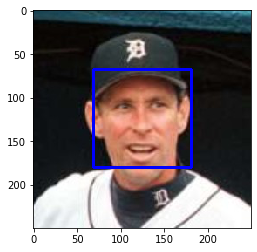



Hello human!
The resembling dog breed is American foxhound
Number of faces detected: 1


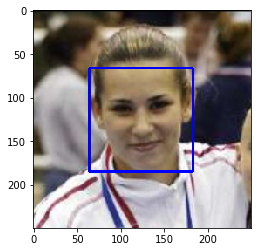



Hello human!
The resembling dog breed is Chihuahua
Number of faces detected: 1


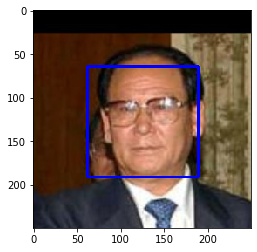



It's a doggo!
The breed is Plott
Number of faces detected: 0


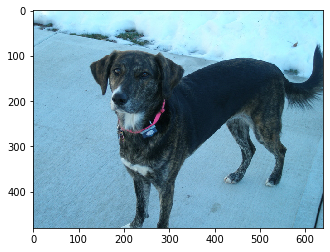



It's a doggo!
The breed is Plott
Number of faces detected: 0


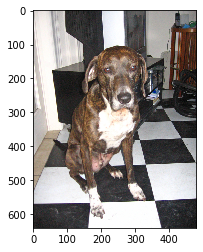



It's a doggo!
The breed is Plott
Number of faces detected: 0


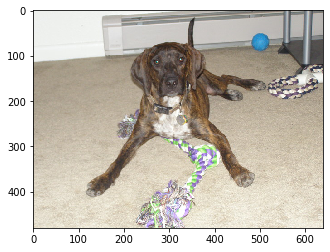

In [330]:
for file in np.hstack((human_files[:3], dog_files[:3])):
    run_app(file)